Preinstallation of modules

In [1]:
#pip install gym[atari]
#pip install ale_py
#pip install autorom[accept-rom-license]
#pip install torch
#conda install pytorch-cuda = 11.6

Imports

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt

Reward Function

In [6]:
class ClipReward(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward

        #Initialising temporary parameters
        self.targetRuns = 0                                 #number of target runs
        self.crashCount=0                                   #number of crashes in a game
        self.ladder=[0]*180                                 #unique y positions

    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reseted and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]
        
        reward = 0
        if(self.pre_pos<current_pos and self.ladder[current_pos]==0):   #is ladder position new?
            reward += 50                                                #Reward for visiting unique (before next target run) position 
            self.ladder[current_pos]=1                                  #ladder position not new anymore
        
        #Chicken reaches the goal
        if 140 <= ram[106] <= 141:
            reward += 10000
            self.targetRuns+=1
        
        reward += (ram[14] * 0.5) - 50                                  #Reward for having current position
        #Chicken got run over
        if 90 <= ram[106] <= 100:
            reward -= 100
            self.crashCount+=1
        else:
            reward += 0
        self.pre_pos = current_pos                                      #Current position will be the previous position in the next transition
        return np.clip(reward, self.min_reward, self.max_reward)
    #get methods
    def getTargetRuns(self):
        return self.targetRuns                                         
    def getCrashCount(self):
        return self.crashCount

    #reset method
    def targetReset(self):                                              #reset temporary parameters
        self.targetRuns = 0
        self.crashCount = 0
        self.ladder=[0]*180

Deep Q Network

In [4]:
class DeepQNetwork(nn.Module):
    #Method to initialize the dqn
    def __init__(self, lr, dims_input, dims_fc1, dims_fc2, n_actions):
        #Inheritance: calling the constructor of the super class
        super(DeepQNetwork, self).__init__()
        #Saving the given parameters
        self.lr = lr                                                #Learning rate
        self.dims_input = dims_input                                #Dimensions of the input
        self.dims_fc1 = dims_fc1                                    #Dimensions of the first fully connected layer
        self.dims_fc2 = dims_fc2                                    #Dimensions of the second fully connected layer
        self.n_actions = n_actions                                  #Number of possible actions

        #On each layer a linear transformation is applied
        self.fc1 = nn.Linear(self.dims_input, self.dims_fc1)
        self.fc2 = nn.Linear(self.dims_fc1, self.dims_fc2)
        self.fc3 = nn.Linear(self.dims_fc2, self.n_actions)

        #Setting up the optimization function which is using the adam algorithm
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        
        #Setting up the mean squared error loss function
        self.loss = nn.MSELoss()

        #Choosing a gpu if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    #Method to calculate actions
    def forward(self, state):
        #Applying the relu activiation function to the first two layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        #No activation function is applied to the outputs
        actions = self.fc3(x)

        #Returing the values for each action
        return actions

Agent

In [11]:
class Agent():
    #Method to initialize the agent
    def __init__(self, gamma, lr, epsilon, eps_dec, eps_end, dims_input, dims_fc1, dims_fc2, batch_size, max_mem_size, n_actions):
        #Saving the given parameters
        self.gamma = gamma                                             #Discount factor
        self.lr = lr                                                   #Learning rate        
        self.epsilon = epsilon                                         #Epsilon start value
        self.eps_dec = eps_dec                                         #Epsilon descent valze
        self.eps_end = eps_end                                         #Epsilon final value
        self.dims_input = dims_input                                   #Dimension of the input
        self.dims_fc1 = dims_fc1                                       #Dimension of the first fully connected layer
        self.dims_fc2 = dims_fc2                                       #Dimension of the second fully connected layer
        self.batch_size = batch_size                                   #Batch size
        self.max_mem_size = max_mem_size                               #Maximum memory size
        self.n_actions = n_actions                                     #Number of possible actions
        self.action_space = [i for i in range(n_actions)]              #Action space
        self.mem_counter = 0                                           #Counter for the memory
        self.runs = 0                                                  #Number of runs

        #Initializing our dqn (which is using two fully conected layers)
        self.Q_eval = DeepQNetwork(self.lr, self.dims_input, self.dims_fc1, self.dims_fc2, self.n_actions)

        #Initializing our memory (state, new state, action, reward & termination)
        self.state_memory = np.zeros((self.max_mem_size, self.dims_input), dtype = np.float32)
        self.new_state_memory = np.zeros((self.max_mem_size, self.dims_input), dtype = np.float32)
        self.action_memory = np.zeros(self.max_mem_size, dtype = np.int32)
        self.reward_memory = np.zeros(self.max_mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype = np.bool_)
    
    #Method to store a transition inside the memory
    def store_transition(self, state, action, reward, state_, done):
        #Determining the storage index
        index = self.mem_counter % self.max_mem_size
        
        #Storing the given state, new state, reward, action and termination information
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        #Increasing the memory counter by one
        self.mem_counter += 1
    
    #Method to choose an action
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            #Exploitation
            state = T.tensor(observation).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            #Choosing the best action (argmax returns the index of the highest value)
            action = T.argmax(actions).item()
        else:
            #Exploration (choosing a random action)
            action = np.random.choice(self.action_space)

        #Returning the selected actions
        return action

    #Method to let the agent learn
    def learn(self):
        if self.mem_counter < self.batch_size:
            #Since the memory is empty at the beginning, we are filling it before the agent starts to learn 
            return
        
        #Setting the gradients of the optimized tensors to zero (otherwise these are cumulated by pytorch)
        self.Q_eval.optimizer.zero_grad()

        #Getting the highest memory index we can reach
        max_mem = min(self.mem_counter, self.max_mem_size)

        #Choosing a random memory entry (as many times as a batch is big)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        #Creating an array with the batch_size in order to slice the calculated values for the actions later on
        batch_index = np.arange(self.batch_size, dtype = np.int32)

        #Getting the states, new states, rewards, actions and termination information for the batch
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]                                            #This is not a tensor since we need it for slicing later
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        #Calculating the estimate during the previous state
        #Additional slicing in order to get the estimate for the action the agent selected 
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]                #The estimates for the actions the agent took
        #Calculating the estimate for the next state
        q_next = self.Q_eval.forward(new_state_batch)
        #Setting values of terminal states to zero (there are no next states after the game finished)
        q_next[terminal_batch] = 0.0
        #Calculating the target values
        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]
        #Calculating the loss (via mean squared error)
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        #Perfoming backpropagation
        loss.backward()
        #Updating (optimizing) the parameters 
        self.Q_eval.optimizer.step()

        #Increasing the number of runs
        self.runs += 1

    #Method to recieve a model
    def getModel(self):
        return self.Q_eval

    #Method to set a trained model
    def setModel(self, path):
        self.Q_eval = T.load(path)

    #Method to decrease the epsilon value
    def decreaseEpsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if (self.epsilon - self.eps_dec) > self.eps_end else self.eps_end

    #Methode to increase the discount factor gamma
    def increaseGamma(self, increment):
        self.gamma = self.gamma + increment

Epsilon Decrease Calculator

In [16]:
gue=50                              #games until final epsilon value
efv=0.01                            #Epsilon final value, Set 0.0 for testing of trained Model
ep_dec_calc=(1.0-efv)/gue           #calculated epsilon decrease per game
print(ep_dec_calc)

0.019799999999999998


Modell Trainer

Episode:  0 , Cumulative reward:  -4000 , Epsilon: 1.00000000 , Target runs:  0 Crashes:  57
----------------------------------------------------------------------------
In this run we used the follwing parameters:
    Epsilon start value: 1.0
    Epsilon descent value: 0.99
    Epsilon final value: 0.01
    Learning rate: 0.005
    Discount factor: 0.99
    Dimension of the input: 13
    Dimension of the first fully connected layer: 1024
    Dimension of the second fully connected layer: 1024
    Batch size: 64
    Maximum memory size: 1000000
    Number of possible actions: 3
    Number of games: 1
    Maximum reward: 10000
    Minimum reward: -100


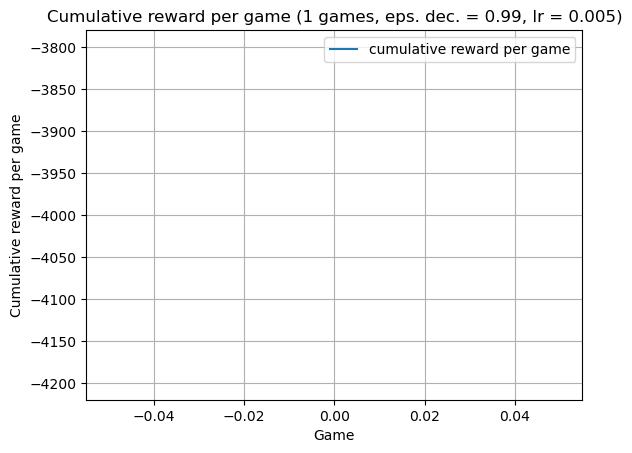

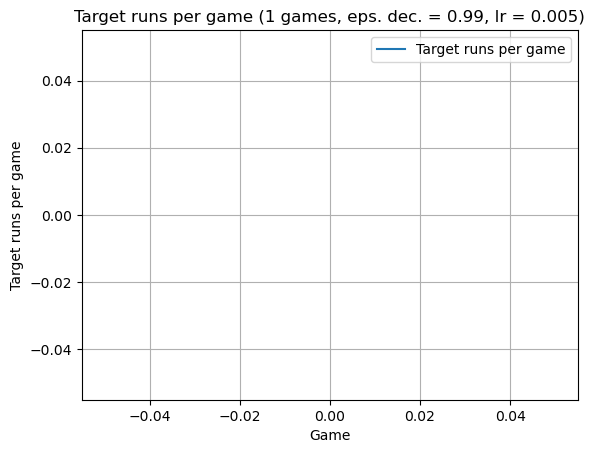

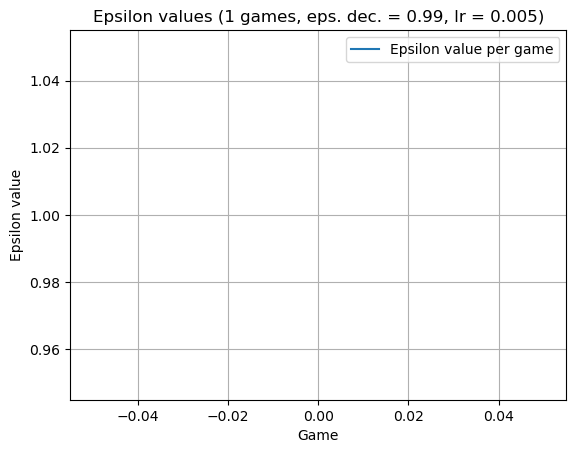

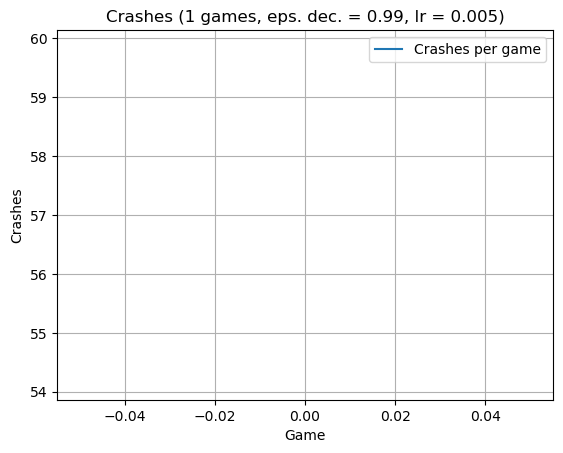

In [17]:
#Setting all relevant parameters for the dqn:
p_n_games = 50                       #Number of games
gue=p_n_games**0.75                 #games until final epsilon value
p_epsilon = 1.0                     #Epsilon start value, Set 0.0 for testing of trained Model
p_eps_end = .01                     #Epsilon final value, Set 0.0 for testing of trained Model
p_eps_dec = (1.0-p_eps_end)/gue     #Epsilon descent value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 13                   #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_max_reward = 10000                #Maximum reward
p_min_reward = -100                 #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 50                #Reward for moving to a new Position ("new" Resets on achieving a target run)
reward_backwards = 0                #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -100                 #Reward for colliding with a car
training = 0                        #0: load Model, >0: Model training without preloaded Model, 1 or < 0: Save model
name = "TestCroppedRAMv1_3_ClipReward"                      #Name of to be saved/loaded model
path = "C:\\Users\Simon\projektSeminar\Modelle"             #directory of the model

#Creating the environment and the agent
if(training<=0):
    if(training==0):
        p_eps_end,p_eps_dec=0.0     #Testing loaded model without additional training
    env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram",render_mode='human'), p_min_reward, p_max_reward)
    agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)
    agent.setModel(f"{path}\{name}.pth")
else:
    env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
    agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list, crashes = [], [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    #overriding the first state to conform input dimensions
    ram = env.unwrapped.ale.getRAM()
    observation=[ram[14],ram[103],ram[108], ram[109], ram[110], ram[111], ram[112], ram[113], ram[114], ram[115], ram[116], ram[117], ram[118]] 

    while not done:
        #Receiving current observation space as RAM
        ram = env.unwrapped.ale.getRAM()

        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Overriding observation_ with cropped RAM
        observation_=[ram[14],ram[103],ram[108], ram[109], ram[110], ram[111], ram[112], ram[113], ram[114], ram[115], ram[116], ram[117], ram[118]] 

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = env.getTargetRuns()

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)
    crashes.append(env.getCrashCount())

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs,'Crashes: ', crashes[i])

    #Resetting the number of target runs
    env.targetReset()

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = f"{path}\{name}_{i}.pth"
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
if(training<0 or training==1):
    T.save(Agent.getModel(agent), f"{path}\{name}.pth")

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, crashes, label = "Crashes per game")                                            #Crashes per game
plt.title(f"Crashes ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Crashes")
plt.legend()
plt.grid()
plt.show()